# Proyecto final:  

## Regularización con 3-bloques-cnn + Dropout + BatchNormalization + DataAugmentation

### Francisco Leonid Galvez Flores


In [1]:
# importar las librerías a utilizar
from tensorflow.keras.utils import to_categorical             # para convertir etiquetas numéricas a binarias (One Hot)
from tensorflow.keras import models, layers, optimizers       # para configurar la red neuronal
from tensorflow.keras.datasets import cifar10                 # utilizaremos el conjunto de datos cifar10
from tensorflow.keras import regularizers                     # para mejorar el entrenamiento y controlar el sobreentrenamiento
from tensorflow.keras.preprocessing.image import ImageDataGenerator    # para aumentar ejemplos de entrenamiento
import numpy as np                                            # para cálculos con matrices
import time                                                   # funciones de tiempo
import os                                                     # rutinas del sisema operativo

In [2]:
# importar más librerías
import sklearn.model_selection as model_selection                        # manipulación de datos de entrenamiento y validación
import matplotlib.pyplot as plt                                          # generación de gráficos
from sklearn.metrics import confusion_matrix, classification_report      # estadísticas sobre resultado de la clasificación

In [3]:
import tensorflow as tf      # para importar interfaces de tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
print('Total de gpus en uso: ', len(gpus))

Total de gpus en uso:  0


170508288/170498071 [==============================] - 8s 0us/step
Datos de entrenamiento    : (50000, 32, 32, 3)
Etiquedas de entrenamiento: (50000, 1)
Datos de validacion       : (10000, 32, 32, 3)
Etiquetas de validacion   : (10000, 1)


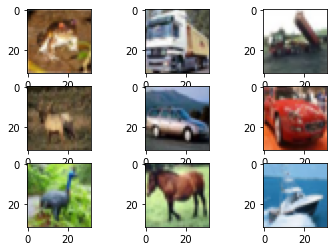

In [4]:
((trainX, trainY), (validationX, validationY)) = cifar10.load_data()

# desplegamos las dimensiones de los datos de entrenamiento y validación
print("Datos de entrenamiento    :", trainX.shape)
print("Etiquedas de entrenamiento:", trainY.shape)
print("Datos de validacion       :", validationX.shape)
print("Etiquetas de validacion   :", validationY.shape)

# imágenes de muestra
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(trainX[i])
plt.show()

In [5]:
# INTRODUCIMOS LAS VARIABLES DE CANTIDAD DE DATOS DE ENTRENAMIENTO Y VALIDACIÓN
train_size = int(50000 * 0.70)
test_size = int(50000 * 0.30)

trainx, validationx, trainy, validationy = model_selection.train_test_split(trainX, trainY, 
                                                                            train_size=train_size,  
                                                                            test_size=test_size,    
                                                                            random_state=17)        

# desplegamos las dimensiones de los datos de entrenamiento y validación
print("Datos de entrenamiento    :", trainx.shape)
print("Etiquedas de entrenamiento:", trainy.shape)
print("Datos de validacion       :", validationx.shape)
print("Etiquetas de validacion   :", validationy.shape)

Datos de entrenamiento    : (35000, 32, 32, 3)
Etiquedas de entrenamiento: (35000, 1)
Datos de validacion       : (15000, 32, 32, 3)
Etiquetas de validacion   : (15000, 1)


In [6]:
# conversión de las intensidades de los píxeles del rango 0-255 al rango 0.0-1.0
x_train, x_validation = trainx/255.0, validationx/255.0
print("Datos de entrenamiento    :", x_train.shape)
print("Datos de validacion       :", x_validation.shape)

# conversión de las etiquetas de enteros a vectores one hot
y_train = to_categorical(trainy)
y_validation = to_categorical(validationy)
print("Etiquedas de entrenamiento:", y_train.shape)
print("Etiquedas de validación   :", y_validation.shape)

Datos de entrenamiento    : (35000, 32, 32, 3)
Datos de validacion       : (15000, 32, 32, 3)
Etiquedas de entrenamiento: (35000, 10)
Etiquedas de validación   : (15000, 10)


# Definimos hiper-parámetros

In [7]:
n_epochs = 1
n_batch = 64
lrate = 0.0001     

Contruimos la red neuronal de convolución

In [8]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='tanh', input_shape=(32,32,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='tanh'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='tanh'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='tanh'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='tanh'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='tanh'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(10, activation='softmax'))

In [9]:
opt = optimizers.RMSprop(learning_rate=lrate)

model.compile(optimizer=opt, 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

Utilizamos un generador de datos para aumentar la cantidad de imágenes.

In [10]:
# creamos el generador de datos
datagen = ImageDataGenerator(width_shift_range=0.1, 
                             height_shift_range=0.1, 
                             horizontal_flip=True)
# preparamos el iterador
it_train = datagen.flow(x_train, y_train, batch_size=64)

steps = int(x_train.shape[0] / n_batch)

In [ ]:
# tiempo de inicio
t1=time.time()
# entrenamos el modelo
H = model.fit(it_train,  
               steps_per_epoch=steps,
               epochs=n_epochs, 
               validation_data=(x_validation, y_validation),   
               verbose=2) 
# tiempo de terminación
t2=time.time()
ttff="{:.2f}".format(t2-t1)
print("Tiempo de entrenamiento (segs): " + str(ttff)) 

546/546 - 229s - loss: 2.3983 - accuracy: 0.1879 - val_loss: 1.8754 - val_accuracy: 0.3413 - 229s/epoch - 420ms/step
Tiempo de entrenamiento (segs): 263.99


Mostrar el historial de entrenamiento y validación.

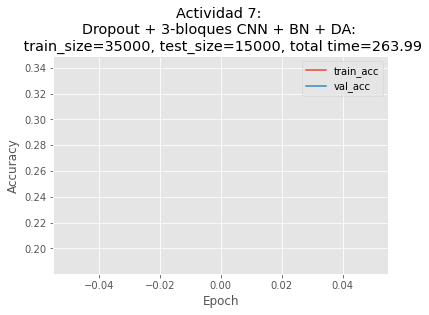

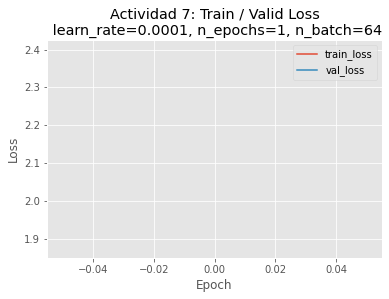

<Figure size 432x288 with 0 Axes>

In [ ]:
# Gráficas del historial de entrenamiento y validación:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,n_epochs),H.history["accuracy"],label="train_acc")
plt.plot(np.arange(0,n_epochs),H.history["val_accuracy"],label="val_acc")
plt.title("Actividad 7: \nDropout + 3-bloques CNN + BN + DA: \n train_size=" + str(train_size) + 
          ", test_size=" + str(test_size) + ", total time=" + str(ttff))      
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(np.arange(0,n_epochs),H.history["loss"],label="train_loss") 
plt.plot(np.arange(0,n_epochs),H.history["val_loss"],label="val_loss")
plt.title("Actividad 7: Train / Valid Loss\n learn_rate=" + str(lrate) + 
          ", n_epochs=" + str(n_epochs) + ", n_batch=" + str(n_batch))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()
plt.savefig('plot07.jpg')

# Estadísticas sobre desempeño del modelo.

In [ ]:
# Etiquetas de las categorías de imágenes
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# estadísticas de desempeño de la red
predictions = model.predict(x_validation, batch_size=n_batch)
print(classification_report(y_validation.argmax(axis=1), 
      predictions.argmax(axis=1),target_names=labels))

              precision    recall  f1-score   support

    airplane       0.39      0.57      0.46      1477
  automobile       0.43      0.25      0.31      1491
        bird       0.32      0.10      0.16      1489
         cat       0.30      0.06      0.09      1557
        deer       0.29      0.29      0.29      1476
         dog       0.41      0.11      0.17      1515
        frog       0.28      0.74      0.40      1486
       horse       0.28      0.37      0.32      1483
        ship       0.53      0.40      0.46      1519
       truck       0.37      0.54      0.44      1507

    accuracy                           0.34     15000
   macro avg       0.36      0.34      0.31     15000
weighted avg       0.36      0.34      0.31     15000



In [ ]:
# Matriz de confusión
confusion_matrix(y_validation.argmax(axis=1), predictions.argmax(axis=1))

array([[ 841,   40,   31,   10,   68,   11,   94,   73,  159,  150],
       [  82,  367,   16,   23,   78,   20,  130,  127,   84,  564],
       [ 241,   37,  155,   30,  317,   17,  431,  156,   38,   67],
       [  88,   74,   67,   86,   66,  100,  608,  304,   64,  100],
       [ 128,   31,   69,   27,  426,    8,  531,  178,   23,   55],
       [  72,   49,   84,   49,  121,  160,  447,  413,   62,   58],
       [  31,   33,   20,    8,  121,    4, 1106,  103,   12,   48],
       [  80,   32,   26,   30,  191,   27,  434,  556,   11,   96],
       [ 489,   44,   10,    9,   20,   32,   48,   35,  613,  219],
       [ 103,  142,   13,   15,   80,    9,  171,   75,   89,  810]])

In [ ]:
# Arquitectura de la red
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [ ]:
# salvar el modelo entrenado
model.save('modeloCIFAR_with_all_300_epochs.h5')